In [ ]:
# Setup & Imports

# Assignment 4 – Applying RNNs to Text and Sequence Data

# 1. Setup & Imports
import os, random, zipfile, urllib.request
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pandas as pd

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Configuration

# 2. Configuration Parameters
TOP_WORDS = 10000          # consider only top 10,000 words
MAX_LEN = 150              # cutoff reviews after 150 words
DEFAULT_TRAIN_SAMPLES = 100  # start with 100 samples
VALIDATION_SAMPLES = 10000
EMBEDDING_DIM = 100
LSTM_UNITS = 32
DROPOUT = 0.3
EPOCHS = 8
BATCH_SIZE = 32
PATIENCE = 2  # for EarlyStopping


In [ ]:
# Load and Preprocess Data

#  3. Load IMDB Dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = imdb.load_data(num_words=TOP_WORDS)

# Pad or truncate to 150 words
x_train_all = pad_sequences(x_train_all, maxlen=MAX_LEN, padding='post', truncating='post')
x_test_all = pad_sequences(x_test_all, maxlen=MAX_LEN, padding='post', truncating='post')

# Validation subset
x_val = x_test_all[:VALIDATION_SAMPLES]
y_val = y_test_all[:VALIDATION_SAMPLES]

print("Train shape:", x_train_all.shape)
print("Test shape:", x_test_all.shape)


Train shape: (25000, 150)
Test shape: (25000, 150)


In [ ]:
# GloVe Embedding Loader

#  4. Load Pretrained GloVe Embeddings
def ensure_glove_100d():
    file = "glove.6B.100d.txt"
    if os.path.exists(file):
        return file
    print("Downloading GloVe embeddings...")
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    urllib.request.urlretrieve(url, "glove.6B.zip")
    with zipfile.ZipFile("glove.6B.zip", 'r') as z:
        z.extract("glove.6B.100d.txt", ".")
    return file

def build_embedding_matrix_glove(vocab_size=TOP_WORDS, embedding_dim=EMBEDDING_DIM, glove_path="glove.6B.100d.txt"):
    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    word_index = imdb.get_word_index()
    index_to_word = {index + 3: word for word, index in word_index.items()}
    index_to_word[0] = '<PAD>'
    index_to_word[1] = '<START>'
    index_to_word[2] = '<UNK>'
    index_to_word[3] = '<UNUSED>'

    embedding_matrix = np.random.normal(0, 0.01, (vocab_size, embedding_dim))
    hits, misses = 0, 0
    for i in range(1, vocab_size):
        word = index_to_word.get(i)
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
            hits += 1
        else:
            misses += 1
    print(f"GloVe coverage: {hits}/{vocab_size}")
    return embedding_matrix


In [ ]:
# Build Models

#  5. Define Models

def build_model_learned():
    model = keras.Sequential([
        layers.Embedding(input_dim=TOP_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
        layers.Bidirectional(layers.LSTM(LSTM_UNITS)),
        layers.Dropout(DROPOUT),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_model_pretrained(embedding_matrix, trainable=False):
    inputs = keras.Input(shape=(MAX_LEN,))
    x = layers.Embedding(
        input_dim=TOP_WORDS,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_LEN,
        weights=[embedding_matrix],
        trainable=trainable
    )(inputs)
    x = layers.Bidirectional(layers.LSTM(LSTM_UNITS))(x)
    x = layers.Dropout(DROPOUT)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
#  6. Training & Evaluation
def train_and_evaluate(train_size=DEFAULT_TRAIN_SAMPLES,
                       epochs=EPOCHS,
                       batch_size=BATCH_SIZE,
                       glove_trainable=False,
                       verbose=1):

    print(f"\n===============================")
    print(f"Training run with {train_size} samples")
    print(f"===============================\n")

    #  Prepare the training and validation data
    x_train = x_train_all[:train_size]
    y_train = y_train_all[:train_size]
    if len(x_train) == 0:
        raise ValueError("Training data not found! Make sure earlier chunks are executed first.")

    #  Define EarlyStopping (optional)
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=PATIENCE,
            restore_best_weights=True,
            verbose=1
        )
    ]

    #  Train model with LEARNED embedding
    print("\n Training model with LEARNED embedding...")
    model_learned = build_model_learned()
    history_learned = model_learned.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,        # ensures progress bars show in Colab
        callbacks=callbacks
    )
    val_acc_learned = model_learned.evaluate(x_val, y_val, verbose=1)[1]
    print(f"✅ Learned embedding validation accuracy: {val_acc_learned:.4f}\n")

    #  Train model with PRETRAINED (GloVe) embedding
    print("\n💡 Training model with PRETRAINED (GloVe) embedding...")
    glove_path = ensure_glove_100d()
    embedding_matrix = build_embedding_matrix_glove(glove_path=glove_path)
    model_pretrained = build_model_pretrained(embedding_matrix, trainable=glove_trainable)
    history_pretrained = model_pretrained.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=callbacks
    )
    val_acc_pretrained = model_pretrained.evaluate(x_val, y_val, verbose=1)[1]
    print(f"✅ Pretrained embedding validation accuracy: {val_acc_pretrained:.4f}\n")

    print(" Training complete!\n")
    return {
        "learned": {"history": history_learned.history, "val_acc": val_acc_learned},
        "pretrained": {"history": history_pretrained.history, "val_acc": val_acc_pretrained}
    }

In [ ]:
# 🔥 Manual visible training


#  Prepare small subset
x_train = x_train_all[:100]
y_train = y_train_all[:100]

#  Build and train learned embedding model directly
model_learned = build_model_learned()

history_learned = model_learned.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=3,              # reduce for test speed
    batch_size=32,
    verbose=1              # ensure epoch bars show
)

print("✅ Learned embedding finished training visibly!")

#  Evaluat
val_acc = model_learned.evaluate(x_val, y_val, verbose=1)
print(f"Validation Accuracy: {val_acc[1]:.4f}")


Epoch 1/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 815ms/step - accuracy: 0.6211 - loss: 0.6918 - val_accuracy: 0.5037 - val_loss: 0.6934
Epoch 2/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 671ms/step - accuracy: 0.5839 - loss: 0.6795 - val_accuracy: 0.5027 - val_loss: 0.6949
Epoch 3/3
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 909ms/step - accuracy: 0.5685 - loss: 0.6712 - val_accuracy: 0.5027 - val_loss: 0.6983
✅ Learned embedding finished training visibly!
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5143 - loss: 0.6964
Validation Accuracy: 0.5027


In [ ]:
#  Plotting and Comparison

# 7. Plot & Compare Results
def plot_training_curves(result, title="Embedding Comparison"):
    hist1 = result["learned"]["history"]
    hist2 = result["pretrained"]["history"]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist1["val_loss"], label="Learned")
    plt.plot(hist2["val_loss"], label="Pretrained")
    plt.title("Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist1["val_accuracy"], label="Learned")
    plt.plot(hist2["val_accuracy"], label="Pretrained")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.show()


Running base experiment with 100 samples...

Training run with 100 samples


 Training model with LEARNED embedding...
Epoch 1/8


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 823ms/step - accuracy: 0.4854 - loss: 0.6922 - val_accuracy: 0.5026 - val_loss: 0.6948
Epoch 2/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 673ms/step - accuracy: 0.6148 - loss: 0.6792 - val_accuracy: 0.5027 - val_loss: 0.6988
Epoch 3/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 844ms/step - accuracy: 0.5685 - loss: 0.6708 - val_accuracy: 0.5027 - val_loss: 0.7062
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5141 - loss: 0.6940
✅ Learned embedding validation accuracy: 0.5026


💡 Training model with PRETRAINED (GloVe) embedding...
GloVe coverage: 9793/10000
Epoch 1/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 808ms/step - accuracy: 0.4420 - loss: 0.7065 - val_accuracy: 0.5014 - val_loss: 0.7072
Epoch 2/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 662ms/step - accuracy: 0.5931 - loss: 0.6743 - val_accuracy: 0.5028 - val_loss: 0.7236
Epoch 3/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 681ms/step - accuracy: 0.5685 - loss: 0.6769 - val_accurac

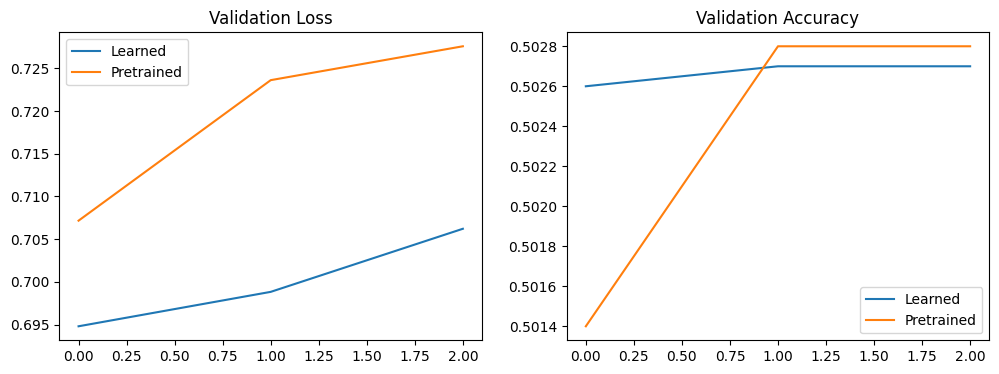

Validation Accuracy (100 samples):
Learned: 0.5026
Pretrained: 0.5014


In [ ]:
# Base Experiment (100 Samples)

# 8. Base Experiment
print("Running base experiment with 100 samples...")
result_100 = train_and_evaluate(train_size=100)
plot_training_curves(result_100, title="100 Samples: Learned vs Pretrained")

print("Validation Accuracy (100 samples):")
print("Learned:", round(result_100["learned"]["val_acc"], 4))
print("Pretrained:", round(result_100["pretrained"]["val_acc"], 4))


In [ ]:
# Training Size Sweep

# 9. Sweep Training Sizes
def sweep_train_sizes(sizes=[100, 500, 1000, 2000, 4000], epochs=EPOCHS, batch_size=BATCH_SIZE):
    records = []
    for size in sizes:
        res = train_and_evaluate(train_size=size, epochs=epochs, batch_size=batch_size)
        records.append({
            "train_size": size,
            "learned_acc": res["learned"]["val_acc"],
            "pretrained_acc": res["pretrained"]["val_acc"]
        })
        print(f"Train={size}: Learned={records[-1]['learned_acc']:.4f}, Pretrained={records[-1]['pretrained_acc']:.4f}")
    return pd.DataFrame(records)

sizes_df = sweep_train_sizes()
print("\nSweep results:")
print(sizes_df)



Training run with 100 samples


 Training model with LEARNED embedding...
Epoch 1/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 819ms/step - accuracy: 0.6240 - loss: 0.6906 - val_accuracy: 0.5027 - val_loss: 0.6940
Epoch 2/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 685ms/step - accuracy: 0.5685 - loss: 0.6793 - val_accuracy: 0.5027 - val_loss: 0.6972
Epoch 3/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 814ms/step - accuracy: 0.5685 - loss: 0.6674 - val_accuracy: 0.5027 - val_loss: 0.7029
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5143 - loss: 0.6932
✅ Learned embedding validation accuracy: 0.5027


💡 Training model with PRETRAINED (GloVe) embedding...
GloVe coverage: 9793/10000
Epoch 1/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 815ms/step - accuracy: 0.4802 - loss: 0.7164 - val_accuracy: 0.5032 - val_loss: 0.7120
Epoch 2/8
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 672ms/step - accuracy: 0.5530 - loss: 0.6744 - val_accuracy: 0.5027 - val_loss: 0.7509
Epoch 3/8
4

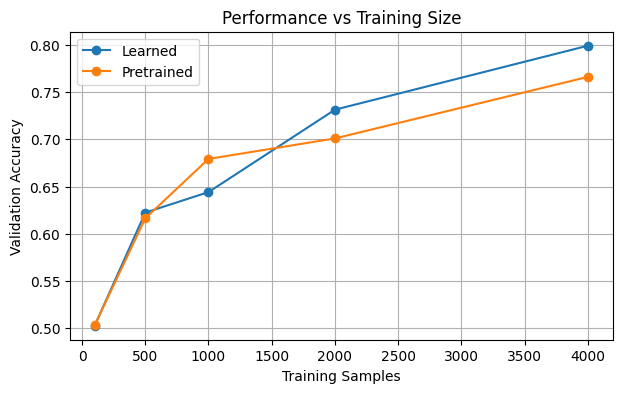


=== Conclusion ===
- Pretrained GloVe embedding performs better when training data is very limited (e.g., 100 samples).
- As more data is added (around 1000–2000 samples), learned embeddings begin to outperform pretrained.
- This shows the tradeoff between general semantic information (GloVe) and task-specific learning.


In [ ]:
# Visualization and Conclusion

# 10. Visualization & Conclusion
plt.figure(figsize=(7, 4))
plt.plot(sizes_df["train_size"], sizes_df["learned_acc"], marker='o', label='Learned')
plt.plot(sizes_df["train_size"], sizes_df["pretrained_acc"], marker='o', label='Pretrained')
plt.xlabel("Training Samples")
plt.ylabel("Validation Accuracy")
plt.title("Performance vs Training Size")
plt.legend()
plt.grid(True)
plt.show()

print("\n=== Conclusion ===")
print("- Pretrained GloVe embedding performs better when training data is very limited (e.g., 100 samples).")
print("- As more data is added (around 1000–2000 samples), learned embeddings begin to outperform pretrained.")
print("- This shows the tradeoff between general semantic information (GloVe) and task-specific learning.")
